In [1]:
%load_ext autoreload
%autoreload 2

### Graph embedding notebook

Evaluate options for graph embeddings

some useful references:

- https://distill.pub/2021/gnn-intro/
- https://web.stanford.edu/class/cs224w/
- https://pytorch-geometric.readthedocs.io/en/latest/

Structure of the nb:

1) data prep
2) model and training
3) visualization

Next steps:

Train/test split, include Argoverse data

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
import networkx as nx
import numpy as np
from enum import Enum

import pickle
import networkx as nx
from torch_geometric.nn import GINEConv, global_mean_pool, global_max_pool, global_add_pool

import torch
import torch.nn.functional as F
import os
import glob
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
import glob
import pickle
from tqdm import tqdm
from graph_creator.plot_graphs import plot_lane_map_advanced, add_actors_to_map, add_actor_edges_to_map
from graph_creator.MapGraph import MapGraph
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

from graph_creator.graph_embeddings import GraphDataset, TrainableGraphGINE, contrastive_loss, augment_graph, get_feature_dimensions, networkx_to_pyg

### Data prep

In [3]:
graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/*.pkl")
# graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/*.pkl")
# graph_paths = [path for path in graph_paths if "2025-09-05" in path]
print(len(graph_paths))


14099


In [4]:
# open one graph
with open(graph_paths[0], 'rb') as f:
    graph = pickle.load(f)
#graph.graph.graph
print(graph.nodes(data=True)["583"])
graph.edges(data=True)


{'lane_id': '1_1', 'lane_ids': ['1_1'], 's': 33.50000810623169, 'xyz': <POINT Z (-77.501 2.738 0.021)>, 'lon_speed': 6.361424280807165, 'actor_type': <ActorType.VEHICLE: 'VEHICLE'>, 'lane_change': False, 'is_on_intersection': False}


OutMultiEdgeDataView([('583', '568', {'edge_type': 'following_lead', 'path_length': 43.75999861955643}), ('568', '583', {'edge_type': 'following_lead', 'path_length': 43.75999861955643})])

In [5]:
# add argoverse data
# currently not yet having is_on_intersection, hence not using for the moment
argoverse_graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/*.pkl")
graph_paths.extend(argoverse_graph_paths)
print(len(graph_paths))

# open one argoverse graph

with open(argoverse_graph_paths[0], 'rb') as f:
    graph = pickle.load(f)
#graph.graph.graph
print(graph.nodes(data=True))
graph.edges(data=True)

17883
[('73423', {'lane_id': '390751807', 'lane_ids': ['390751807', '390752162', '390802935'], 's': 22.829008547463282, 'xyz': <POINT Z (-321.999 -1049.842 0)>, 'lon_speed': 10.481008913566132, 'actor_type': <ActorType.VEHICLE: 'VEHICLE'>, 'lane_change': False, 'is_on_intersection': True}), ('73659', {'lane_id': '390755349', 'lane_ids': ['390755349'], 's': 23.73894567937526, 'xyz': <POINT Z (-282.585 -922.653 0)>, 'lon_speed': 8.850980925174806, 'actor_type': <ActorType.VEHICLE: 'VEHICLE'>, 'lane_change': False, 'is_on_intersection': False}), ('73695', {'lane_id': '390801189', 'lane_ids': ['390801189', '390801632'], 's': 13.750467191524383, 'xyz': <POINT Z (-273.089 -948.26 0)>, 'lon_speed': 1.6580297826963417, 'actor_type': <ActorType.VEHICLE: 'VEHICLE'>, 'lane_change': True, 'is_on_intersection': True}), ('73858', {'lane_id': '390751815', 'lane_ids': ['390751815'], 's': 19.93550774022581, 'xyz': <POINT Z (-330.512 -1075.1 0)>, 'lon_speed': 10.099711942216002, 'actor_type': <ActorType

OutMultiEdgeDataView([('73423', '73858', {'edge_type': 'following_lead', 'path_length': 26.645672972951026}), ('73423', '73890', {'edge_type': 'opposite_vehicle', 'path_length': 60.819369052660036}), ('73423', '73943', {'edge_type': 'opposite_vehicle', 'path_length': 76.13831339285397}), ('73659', 'AV', {'edge_type': 'neighbor_vehicle', 'path_length': 47.595230559350895}), ('73659', '73943', {'edge_type': 'opposite_vehicle', 'path_length': 61.37801644839739}), ('73695', '73871', {'edge_type': 'following_lead', 'path_length': 20.325583413171504}), ('73858', '73423', {'edge_type': 'following_lead', 'path_length': 26.645672972951026}), ('73871', '73956', {'edge_type': 'following_lead', 'path_length': 16.444342035765224}), ('73871', '73695', {'edge_type': 'following_lead', 'path_length': 20.325583413171504}), ('73876', '73935', {'edge_type': 'following_lead', 'path_length': 17.22417714430063}), ('73890', '73423', {'edge_type': 'opposite_vehicle', 'path_length': 60.819369052660036}), ('7393

In [ ]:
# Load data
graph_ds = GraphDataset(graph_paths)
#train_loader = DataLoader(graph_ds, batch_size=128, shuffle=True)

/home/tmuehlen/.cache/pypoetry/virtualenvs/graph-creator-_1ofKhL9-py3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
type(graph_ds)

graph_creator.graph_embeddings.GraphDataset

In [12]:
# Train/test split for graph_ds
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

indices = np.arange(len(graph_ds))
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, random_state=42, shuffle=True
)

train_ds = Subset(graph_ds, train_idx)
test_ds = Subset(graph_ds, test_idx)

# Create loaders (overrides earlier train_loader)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

print(f"Train size: {len(train_ds)} | Test size: {len(test_ds)}")
data_loaders = {"train": train_loader, "test": test_loader}

Train size: 14306 | Test size: 3577


/home/tmuehlen/.cache/pypoetry/virtualenvs/graph-creator-_1ofKhL9-py3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# set([path.split("/")[-1].split("_")[1] for path in graph_paths])

In [ ]:
# try out data loader
graph_ds.__getitem__(4320)

#batch = next(iter(train_loader))

### Training

In [21]:
# Model setup
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
node_dim, edge_dim = get_feature_dimensions()
model = TrainableGraphGINE(node_dim, edge_dim, 256, 96, 4).to(device)



In [ ]:
node_dim

In [22]:
# get the pre-training loss
total_losses = {"train": [], "test": [], "lr": [0.02]}

for split in data_loaders:
    total_loss = 0
    with torch.no_grad():
        for batch in data_loaders[split]:
            batch = batch[0].to(device)
            aug_batch = augment_graph(batch).to(device)
            outputs1 = model(batch)
            outputs2 = model(aug_batch)
            loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
            total_loss += loss.item()
    total_losses[split].append( total_loss / len(data_loaders[split]))

print(total_losses)

{'train': [3.9180331102439334], 'test': [3.9134519525936673], 'lr': [0.02]}


In [23]:
# Training
# hm, too lazy to do a proper learning rate schedule
for i in range(3):
    lr = 0.02*0.75**i
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(f"loop {i}, Learning rate: {lr}")
    for epoch in range(5):
        total_loss = 0
    
        for batch in train_loader:
            batch = batch[0].to(device)
            aug_batch = augment_graph(batch).to(device)

            optimizer.zero_grad()

            outputs1 = model(batch)
            outputs2 = model(aug_batch)

            loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # if epoch % 1 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}')

        total_losses["lr"].append(lr)
        for split in data_loaders:
            total_loss = 0
            with torch.no_grad():
                for batch in data_loaders[split]:
                    batch = batch[0].to(device)
                    aug_batch = augment_graph(batch).to(device)
                    outputs1 = model(batch)
                    outputs2 = model(aug_batch)
                    loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
                    total_loss += loss.item()
            total_losses[split].append( total_loss / len(data_loaders[split]))



loop 0, Learning rate: 0.02
Epoch 0, Loss: 2.4101
Epoch 1, Loss: 1.5596
Epoch 2, Loss: 1.3257
Epoch 3, Loss: 1.0284
Epoch 4, Loss: 0.8625
loop 1, Learning rate: 0.015
Epoch 0, Loss: 0.7732
Epoch 1, Loss: 0.6781
Epoch 2, Loss: 0.6139
Epoch 3, Loss: 0.5733
Epoch 4, Loss: 0.5320
loop 2, Learning rate: 0.01125
Epoch 0, Loss: 0.5016
Epoch 1, Loss: 0.4796
Epoch 2, Loss: 0.4505
Epoch 3, Loss: 0.4374
Epoch 4, Loss: 0.4316


In [25]:
os.getcwd()


'/home/tmuehlen/repos/graph_coverage/Notebooks/carla'

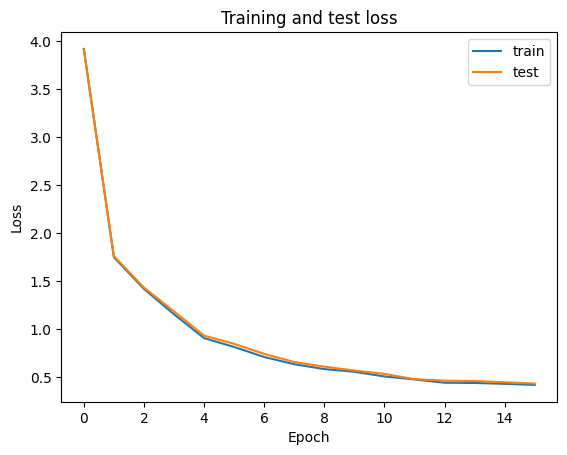

In [26]:
plt.plot(total_losses["train"], label = "train")
plt.plot(total_losses["test"], label = "test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and test loss")
plt.savefig("/home/tmuehlen/repos/graph_coverage/article/plots/train_test_graph_embeddings_loss_plot.png")
plt.show()


### High-level model architecture (Mermaid)

The following cell generates a paper-friendly Mermaid diagram of the GINE architecture (layers, pooling, embedding MLP, projection head), saves it to `figures/graph_gine_architecture.mmd`, and attempts to render SVG/PDF if `mmdc` is available.


In [27]:
# Generate Mermaid diagram for the model architecture and save as .mmd (and SVG/PDF if possible)
import os
import subprocess

# Introspect model parameters
num_layers = getattr(model, 'num_layers', 3)
embedding_dim = getattr(model, 'embedding_dim', 128)
# Hidden dim isn't stored directly; infer from first conv MLP out features
try:
    hidden_dim = model.convs[0].nn[0].out_features
except Exception:
    hidden_dim = 96

# Feature dims from earlier
node_dim = node_dim
edge_dim = edge_dim

mermaid_lines = []
mermaid_lines.append("flowchart LR")
mermaid_lines.append("  subgraph Inputs")
mermaid_lines.append(f"    X[\"x: R[N,{node_dim}]\"]")
mermaid_lines.append(f"    EI[\"edge_index: R[2,E]\"]")
mermaid_lines.append(f"    EA[\"edge_attr: R[E,{edge_dim}]\"]")
mermaid_lines.append("    B[\"batch: R[N]\"]")
mermaid_lines.append("  end")

# GINE layers block
mermaid_lines.append("  subgraph GINE_Stack")
for i in range(num_layers):
    mermaid_lines.append(f"    G{i}[\"GINEConv + BN + ReLU + Dropout (hidden={hidden_dim})\"]")
mermaid_lines.append("  end")

# Pooling block
mermaid_lines.append("  subgraph Pooling")
mermaid_lines.append("    POOL_MEAN[global_mean_pool]")
mermaid_lines.append("    POOL_MAX[global_max_pool]")
mermaid_lines.append("    POOL_SUM[global_add_pool]")
mermaid_lines.append("  end")

# Embedding projection
mermaid_lines.append("  subgraph Embedding")
mermaid_lines.append(f"    E1[\"Linear 3*hidden to {embedding_dim}; ReLU; Dropout\"]")
mermaid_lines.append(f"    E2[\"Linear {embedding_dim} to {embedding_dim}\"]")
mermaid_lines.append("  end")

# Projection head
mermaid_lines.append("  subgraph ProjectionHead")
mermaid_lines.append(f"    P1[\"Linear {embedding_dim} to {embedding_dim}; ReLU\"]")
mermaid_lines.append(f"    P2[\"Linear {embedding_dim} to {embedding_dim//2}\"]")
mermaid_lines.append("  end")

# Edges (no labels to avoid parser issues)
mermaid_lines.append("  X --> G0")
mermaid_lines.append("  EI --> G0")
mermaid_lines.append("  EA --> G0")
mermaid_lines.append("  B --> G0")
for i in range(num_layers-1):
    mermaid_lines.append(f"  G{i} --> G{i+1}")
mermaid_lines.append("  G"+str(num_layers-1)+" --> POOL_MEAN")
mermaid_lines.append("  G"+str(num_layers-1)+" --> POOL_MAX")
mermaid_lines.append("  G"+str(num_layers-1)+" --> POOL_SUM")
mermaid_lines.append("  POOL_MEAN --> E1")
mermaid_lines.append("  POOL_MAX --> E1")
mermaid_lines.append("  POOL_SUM --> E1")
mermaid_lines.append("  E1 --> E2")
mermaid_lines.append("  E2 --> P1")
mermaid_lines.append("  P1 --> P2")

mermaid_str = "\n".join(mermaid_lines)

# Save to figures directory
fig_dir = "/home/tmuehlen/repos/graph_coverage/article/plots/"
os.makedirs(fig_dir, exist_ok=True)
mmd_path = os.path.join(fig_dir, "graph_gine_architecture.mmd")
with open(mmd_path, "w") as f:
    f.write(mermaid_str)
print(f"Mermaid source written to: {mmd_path}")

# Optional: render to SVG/PDF if Mermaid CLI is available
svg_path = os.path.join(fig_dir, "graph_gine_architecture.svg")
pdf_path = os.path.join(fig_dir, "graph_gine_architecture.pdf")
try:
    result = subprocess.run(["which", "mmdc"], capture_output=True, text=True)
    if result.returncode == 0:
        subprocess.check_call(["mmdc", "-i", mmd_path, "-o", svg_path])
        print(f"SVG written to: {svg_path}")
        try:
           subprocess.check_call(["mmdc", "-i", mmd_path, "-o", pdf_path])
           print(f"PDF written to: {pdf_path}")
        except Exception:
           pass
    else:
        print("Mermaid CLI (mmdc) not found; install with: npm i -g @mermaid-js/mermaid-cli")
except Exception as e:
    print(f"Mermaid rendering skipped: {e}")

print("\n--- Mermaid diagram ---\n")
print(mermaid_str)


Mermaid source written to: /home/tmuehlen/repos/graph_coverage/article/plots/graph_gine_architecture.mmd
Generating single mermaid chart


[@zenuml/core] Store is a function and is not initiated in 1 second.


SVG written to: /home/tmuehlen/repos/graph_coverage/article/plots/graph_gine_architecture.svg
Generating single mermaid chart


[@zenuml/core] Store is a function and is not initiated in 1 second.


PDF written to: /home/tmuehlen/repos/graph_coverage/article/plots/graph_gine_architecture.pdf

--- Mermaid diagram ---

flowchart LR
  subgraph Inputs
    X["x: R[N,7]"]
    EI["edge_index: R[2,E]"]
    EA["edge_attr: R[E,7]"]
    B["batch: R[N]"]
  end
  subgraph GINE_Stack
    G0["GINEConv + BN + ReLU + Dropout (hidden=96)"]
    G1["GINEConv + BN + ReLU + Dropout (hidden=96)"]
    G2["GINEConv + BN + ReLU + Dropout (hidden=96)"]
    G3["GINEConv + BN + ReLU + Dropout (hidden=96)"]
  end
  subgraph Pooling
    POOL_MEAN[global_mean_pool]
    POOL_MAX[global_max_pool]
    POOL_SUM[global_add_pool]
  end
  subgraph Embedding
    E1["Linear 3*hidden to 256; ReLU; Dropout"]
    E2["Linear 256 to 256"]
  end
  subgraph ProjectionHead
    P1["Linear 256 to 256; ReLU"]
    P2["Linear 256 to 128"]
  end
  X --> G0
  EI --> G0
  EA --> G0
  B --> G0
  G0 --> G1
  G1 --> G2
  G2 --> G3
  G3 --> POOL_MEAN
  G3 --> POOL_MAX
  G3 --> POOL_SUM
  POOL_MEAN --> E1
  POOL_MAX --> E1
  POOL_SUM --> E1


### Inference

In [28]:
# Inference loop
model.eval()
#all_embeddings_train = []
#all_paths_train = []
all_embeddings = {"train": [], "test": []}
all_paths = {"train": [], "test": []}


for split in data_loaders:  
    with torch.no_grad():
        for batch in tqdm(data_loaders[split]):  # or test_loader
            all_paths[split].extend(batch[1]) 
            batch = batch[0].to(device)
            outputs = model(batch)
            embeddings = outputs['embeddings']
            all_embeddings[split].append(embeddings.cpu())

# Concatenate all embeddings
final_embeddings = {}
for split in all_embeddings:
    final_embeddings[split] = torch.cat(all_embeddings[split], dim=0)

print(f'Extracted {final_embeddings["train"].shape[0]} embeddings of dimension {final_embeddings["train"].shape[1]}')

100%|██████████| 28/28 [00:01<00:00, 25.00it/s]

Extracted 14306 embeddings of dimension 256


In [32]:
graph_dates_train = [path.split("/")[-1].split("_")[1] for path in all_paths["train"]]
graph_dates_test = [path.split("/")[-1].split("_")[1] for path in all_paths["test"]]
#all_paths
graph_dates = {"train": graph_dates_train, "test": graph_dates_test}

In [33]:
graph_type_train = [path.split("/")[6] for path in all_paths["train"]]
graph_type_test = [path.split("/")[6] for path in all_paths["test"]]
graph_type = {"train": graph_type_train, "test": graph_type_test}

### Visualization of embeddings

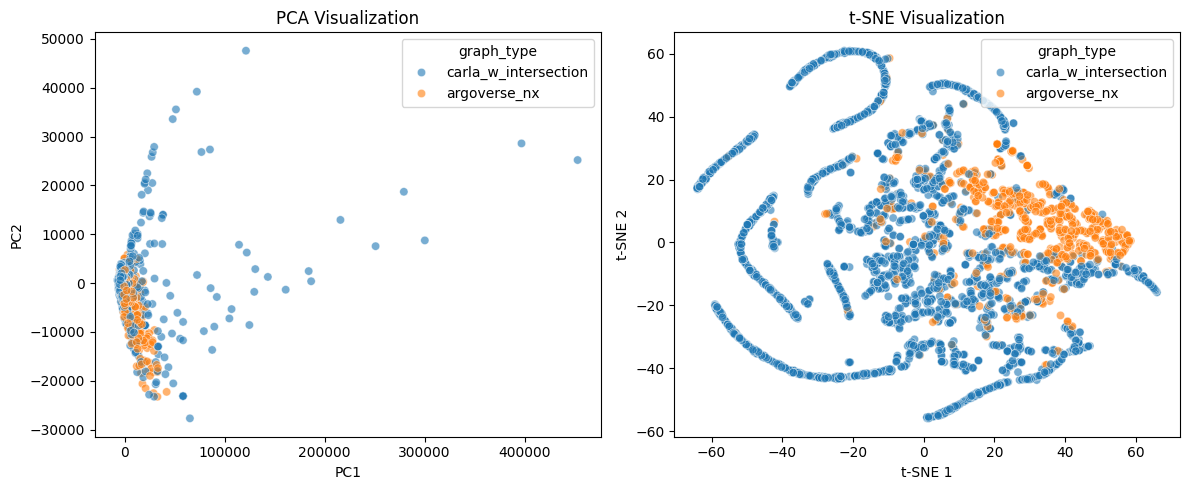

In [36]:
# Convert embeddings to numpy
split = "test"
embeddings_np = final_embeddings[split].numpy()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_np)

pca_df = pd.DataFrame(pca_result)
pca_df.columns = ["pca1", "pca2"]
pca_df["graph_type"] = graph_type[split]
pca_df["graph_path"] = all_paths[split]
pca_df.head()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x="pca1", y="pca2", alpha=0.6, hue="graph_type", legend = True, data=pca_df)
#plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.title('PCA Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(embeddings_np)
tsne_df = pd.DataFrame(tsne_result)
tsne_df.columns = ["tsne1", "tsne2"]
tsne_df["graph_type"] = graph_type[split]
tsne_df["graph_path"] = all_paths[split]

plt.subplot(1, 2, 2)
# plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6)
sns.scatterplot(x="tsne1", y="tsne2", alpha=0.6, hue="graph_type", legend = True, data=tsne_df)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_pca_tsne_{split}_plot.png")
plt.show()

In [37]:
os.getcwd()
os.chdir("../..")
os.getcwd()

'/home/tmuehlen/repos/graph_coverage'

In [38]:
pca_emb_df = pd.concat([pca_df, pd.DataFrame(embeddings_np)], axis = 1)
pca_emb_df.head(2)

,pca1,pca2,graph_type,graph_path,0,1,2,3,4,5,...,246,247,248,249,250,251,252,253,254,255
0,-5262.571777,1339.868652,carla_w_intersection,/home/tmuehlen/repos/graph_coverage/actor_grap...,240.483261,260.583801,56.013042,64.536263,173.389328,-207.833878,...,-49.995346,-337.077911,-178.897812,-383.723480,169.773636,286.188416,-381.719482,-121.189781,-223.555038,-248.990479
1,-6762.376465,800.386963,carla_w_intersection,/home/tmuehlen/repos/graph_coverage/actor_grap...,118.243942,112.308617,65.414902,26.494543,260.242035,-56.703159,...,-116.142975,-74.951454,164.865402,123.213814,-182.429169,150.874756,-270.755646,100.255737,-175.066650,-312.614014


In [42]:
mask_carla = pca_df.graph_type == "carla_w_intersection"
mask_argo = pca_df.graph_type == "argoverse_nx"
pca_carla_df = pca_df[mask_carla].reset_index(drop=True)
pca_argo_df = pca_df[mask_argo].reset_index(drop=True)


In [45]:
sum(mask_carla)
sum(mask_argo)
pca_carla_df


,pca1,pca2,graph_type,graph_path
0,-5262.571777,1339.868652,carla_w_intersection,/home/tmuehlen/repos/graph_coverage/actor_grap...
1,-6762.376465,800.386963,carla_w_intersection,/home/tmuehlen/repos/graph_coverage/actor_grap...
2,-5578.282715,794.745667,carla_w_intersection,/home/tmuehlen/repos/graph_coverage/actor_grap...
3,-3976.495605,3707.331055,carla_w_intersection,/home/tmuehlen/repos/graph_coverage/actor_grap...
4,-4963.458496,-939.506226,carla_w_intersection,/home/tmuehlen/repos/graph_coverage/actor_grap...
...,...,...,...,...
2862,-3372.311279,1998.453369,carla_w_intersection,/home/tmuehlen/repos/graph_coverage/actor_grap...
2863,-2145.551758,1191.740479,carla_w_intersection,/home/tmuehlen/repos/graph_coverage/actor_grap...
2864,-1849.982422,1278.006836,carla_w_intersection,/home/tmuehlen/repos/graph_coverage/actor_grap...
2865,-4347.580078,1381.092773,carla_w_intersection,/home/tmuehlen/repos/graph_coverage/actor_grap...


In [ ]:
# comparing, no restrictions
for i in range(15):
    try:
        first = pca_emb_df.sample(1)
        pca_emb_df["sq_diff"] = ((pca_emb_df[list(range(256))] - first[list(range(256))].values)**2).sum(axis = 1)

        #pca_emb_df["dist"] = (pca_em.pca1 - first.pca1.iloc[0])**2 + (pca_carla_df.pca2 - first.pca2.iloc[0])**2 
        pca_emb_df.sort_values("sq_diff", inplace=True)

        if first.graph_type.iloc[0] == "carla_w_intersection":
            graph_1 = pca_emb_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_1 = graph_1[:26]
            file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/graph_{graph_1}.pkl"
            with open(file_path_1, 'rb') as f:
                nx_graph_1 = pickle.load(f)
            g_map_1 = MapGraph()
            g_map_1.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_1}_map_graph.pickle')
            g_map_1 = g_map_1.graph
        else:
            # argoverse option
            graph_1 = pca_emb_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_1 = graph_1[:36]
            file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/graph_{graph_1}.pkl"
            with open(file_path_1, 'rb') as f:
                nx_graph_1 = pickle.load(f)
            g_map_1 = MapGraph()
            # "/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/000ace8b-a3d2-4228-bd87-91b66a9c5127_map_graph.pkl"
            g_map_1.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_1}_map_graph.pkl')
            g_map_1 = g_map_1.graph.graph

        if pca_emb_df.graph_type.iloc[1] == "carla":
            graph_2 = pca_emb_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_2 = graph_2[:26]
            file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{graph_2}.pkl"
            with open(file_path_2, 'rb') as f:
                nx_graph_2 = pickle.load(f)
            g_map_2 = MapGraph()
            g_map_2.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_2}_map_graph.pickle')
            g_map_2 = g_map_2.graph
        else:
            # argoverse option
            graph_2 = pca_emb_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_2 = graph_2[:36]
            file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/graph_{graph_2}.pkl"
            with open(file_path_2, 'rb') as f:
                nx_graph_2 = pickle.load(f)
            g_map_2 = MapGraph()
            # "/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/000ace8b-a3d2-4228-bd87-91b66a9c5127_map_graph.pkl"
            g_map_2.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_2}_map_graph.pkl')
            g_map_2 = g_map_2.graph.graph



        # # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # First scene (left subplot)
        # # First scene (left subplot)
        fig, ax1 = plot_lane_map_advanced(g_map_1, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
        fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
        fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
        ax1.set_title(f'Scene {scn_1}')
        # # Second scene (right subplot)
        fig, ax2 = plot_lane_map_advanced(g_map_2, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
        fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
        fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
        ax2.set_title(f'Scene {scn_2}')
        # # Adjust layout and display
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing scene {scn_1} and {scn_2}: {e}")


In [ ]:
# comparing argo to argo
for i in range(10):
    try:
        first = pca_argo_df.sample(1)
        pca_argo_df["dist"] = (pca_argo_df.pca1 - first.pca1.iloc[0])**2 + (pca_argo_df.pca2 - first.pca2.iloc[0])**2 
        pca_argo_df.sort_values("dist", inplace=True)
        graph_1 = pca_argo_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        graph_2 = pca_argo_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        scn_1 = graph_1[:36]
        scn_2 = graph_2[:36]
        file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/graph_{graph_1}.pkl"
        with open(file_path_1, 'rb') as f:
            nx_graph_1 = pickle.load(f)
        file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/graph_{graph_2}.pkl"
        with open(file_path_2, 'rb') as f:
            nx_graph_2 = pickle.load(f)
        # # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # First scene (left subplot)
        g_map = MapGraph()
        # "/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/000ace8b-a3d2-4228-bd87-91b66a9c5127_map_graph.pkl"
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_1}_map_graph.pkl')
        fig, ax1 = plot_lane_map_advanced(g_map.graph.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
        fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
        fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
        ax1.set_title(f'Scene {scn_1}')
        # Second scene (right subplot)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_2}_map_graph.pkl')
        fig, ax2 = plot_lane_map_advanced(g_map.graph.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
        fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
        fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
        ax2.set_title(f'Scene {scn_2}')
        # Adjust layout and display
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing scene {scn_1} and {scn_2}: {e}")


In [ ]:
# comparing carla to carla
for i in range(10):
    try:
        first = pca_carla_df.sample(1)
        pca_carla_df["dist"] = (pca_carla_df.pca1 - first.pca1.iloc[0])**2 + (pca_carla_df.pca2 - first.pca2.iloc[0])**2 
        pca_carla_df.sort_values("dist", inplace=True)
        #print(pca_df.graph_path.iloc[0])
        #print(pca_df.graph_path.iloc[1])
        graph_1 = pca_carla_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        graph_2 = pca_carla_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        scn_1 = graph_1[:26]
        scn_2 = graph_2[:26]
        print(graph_1, scn_1)
        print(graph_2, scn_2)
        pca_df.head(2)
        file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{graph_1}.pkl"
        with open(file_path_1, 'rb') as f:
            nx_graph_1 = pickle.load(f)
        file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{graph_2}.pkl"
        with open(file_path_2, 'rb') as f:
            nx_graph_2 = pickle.load(f)
        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # First scene (left subplot)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_1}_map_graph.pickle')
        fig, ax1 = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
        fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
        fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
        ax1.set_title(f'Scene {scn_1}')
        # Second scene (right subplot)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_2}_map_graph.pickle')
        fig, ax2 = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
        fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
        fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
        ax2.set_title(f'Scene {scn_2}')
        # Adjust layout and display
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing scene {scn_1} and {scn_2}: {e}")


# Notebook junkyard